In [1]:
# Styling notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("../src/rise.css", "r").read()
    return HTML(styles)
css_styling()

<h1><center>Space missions data understanding, visualization and analysis</center></h1>

<center><img src="https://specials-images.forbesimg.com/imageserve/5ec807d92ce8db0007986fb2/960x0.jpg?fit=scale"></center>

In [79]:
import numpy as np
import pandas as pd

import plotly.express as px

# !pip install iso3166
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from collections import OrderedDict
import warnings
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

## 1. General dataset overview

In [18]:
df = pd.read_csv('../input/Space_Corrected.csv')

df.columns = [
    'Unnamed: 0', 
    'Unnamed: 0.1', 
    'Company Name', 
    'Location', 
    'Datum', 
    'Detail', 
    'Status Rocket', 
    'Rocket', 
    'Status Mission'
]

df = df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
df.head()

,Company Name,Location,Datum,Detail,Status Rocket,Rocket,Status Mission
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA","Fri Aug 07, 2020 05:12 UTC",Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.0,Success
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...","Thu Aug 06, 2020 04:01 UTC",Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success
2,SpaceX,"Pad A, Boca Chica, Texas, USA","Tue Aug 04, 2020 23:57 UTC",Starship Prototype | 150 Meter Hop,StatusActive,NaN,Success
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan","Thu Jul 30, 2020 21:25 UTC",Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.0,Success
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA","Thu Jul 30, 2020 11:50 UTC",Atlas V 541 | Perseverance,StatusActive,145.0,Success


Let's see percent of NaNs for every column.

In [19]:
missed = pd.DataFrame()
missed['column'] = df.columns
percent = list()

for col in df.columns:
    percent.append(round(100* df[col].isnull().sum() / len(df), 2))

missed['percent'] = percent
missed = missed.sort_values('percent')
missed = missed[missed['percent']>0]

fig = px.bar(
    missed, 
    x='percent', 
    y="column", 
    orientation='h', 
    title='Missed values percent for every column (percent > 0)', 
    width=600,
    height=200 
)

fig.show()

From this short chart we can see that we have only 1 column that contains missed values. It is `Rocket` column with about 80% of missed values.

Now let's see how many launches made every company presented in this dataset.
What about rocket's status?
Now we will check status distribution for all missions.

In [20]:
ds = df['Company Name'].value_counts().reset_index()

ds.columns = [
    'company', 
    'number of starts'
]

ds = ds.sort_values(['number of starts'])

fig = px.bar(
    ds, 
    x='number of starts', 
    y="company", 
    orientation='h', 
    title='Number of launches by every company', 
    width=800,
    height=1000 
)

fig.show()

What about rocket's status?

In [21]:
ds = df['Status Rocket'].value_counts().reset_index()

ds.columns = [
    'status', 
    'count'
]

fig = px.pie(
    ds, 
    values='count', 
    names="status", 
    title='Rocket status', 
    width=500, 
    height=500
)

fig.show()

Now we will check status distribution for all missions.

In [22]:
ds = df['Status Mission'].value_counts().reset_index()

ds.columns = [
    'mission_status', 
    'count'
]

fig = px.bar(
    ds, 
    x='mission_status', 
    y="count", 
    orientation='v', 
    title='Mission Status distribution', 
    width=500,
    height=500
)

fig.show()

And as last part of this section, lets see Value distribution for Rockets. A lot of them have missed values so lets set `0` for this samples.

In [23]:
df['Rocket'] = df['Rocket'].fillna(0.0).str.replace(',', '')
df['Rocket'] = df['Rocket'].astype(np.float64).fillna(0.0)
df['Rocket'] = df['Rocket'] * 1000000

In [24]:
df.loc[df['Rocket']>4000000000, 'Rocket'] = 0.0

fig = px.histogram(
    df, 
    "Rocket", 
    nbins=50, 
    title='Rocket Value distribution', 
    width=700, 
    height=500
)

fig.show()

# 2. Geo analysis

First we need to extract `country` feature and change some country names.

In [25]:
countries_dict = {
    'Russia' : 'Russian Federation',
    'New Mexico' : 'USA',
    "Yellow Sea": 'China',
    "Shahrud Missile Test Site": "Iran",
    "Pacific Missile Range Facility": 'USA',
    "Barents Sea": 'Russian Federation',
    "Gran Canaria": 'USA'
}

df['country'] = df['Location'].str.split(', ').str[-1].replace(countries_dict)

Let's see sunburst chart for countries.

In [26]:
sun = df.groupby(['country', 'Company Name', 'Status Mission'])['Datum'].count().reset_index()

sun.columns = [
    'country', 
    'company', 
    'status', 
    'count'
]

fig = px.sunburst(
    sun, 
    path=[
        'country', 
        'company', 
        'status'
    ], 
    values='count', 
    title='Sunburst chart for all countries',
    width=600,
    height=600
)

fig.show()

Now let's convert country name to Alpha3 format using iso3166 package.

In [28]:
from iso3166 import countries

country_dict = dict()
for c in countries:
    country_dict[c.name] = c.alpha3
    
df['alpha3'] = df['country']
df = df.replace(
    {
        "alpha3": country_dict
    }
)
df.loc[df['country'] == "North Korea", 'alpha3'] = "PRK"
df.loc[df['country'] == "South Korea", 'alpha3'] = "KOR"

df

,Company Name,Location,Datum,Detail,Status Rocket,Rocket,Status Mission,country,alpha3
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA","Fri Aug 07, 2020 05:12 UTC",Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50000000.0,Success,USA,USA
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...","Thu Aug 06, 2020 04:01 UTC",Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29750000.0,Success,China,CHN
2,SpaceX,"Pad A, Boca Chica, Texas, USA","Tue Aug 04, 2020 23:57 UTC",Starship Prototype | 150 Meter Hop,StatusActive,0.0,Success,USA,USA
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan","Thu Jul 30, 2020 21:25 UTC",Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65000000.0,Success,Kazakhstan,KAZ
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA","Thu Jul 30, 2020 11:50 UTC",Atlas V 541 | Perseverance,StatusActive,145000000.0,Success,USA,USA
...,...,...,...,...,...,...,...,...,...
4319,US Navy,"LC-18A, Cape Canaveral AFS, Florida, USA","Wed Feb 05, 1958 07:33 UTC",Vanguard | Vanguard TV3BU,StatusRetired,0.0,Failure,USA,USA
4320,AMBA,"LC-26A, Cape Canaveral AFS, Florida, USA","Sat Feb 01, 1958 03:48 UTC",Juno I | Explorer 1,StatusRetired,0.0,Success,USA,USA
4321,US Navy,"LC-18A, Cape Canaveral AFS, Florida, USA","Fri Dec 06, 1957 16:44 UTC",Vanguard | Vanguard TV3,StatusRetired,0.0,Failure,USA,USA
4322,RVSN USSR,"Site 1/5, Baikonur Cosmodrome, Kazakhstan","Sun Nov 03, 1957 02:30 UTC",Sputnik 8K71PS | Sputnik-2,StatusRetired,0.0,Success,Kazakhstan,KAZ


In [29]:
# This function takes in the dataframe and create a map graph for the specified target column.
def plot_map(dataframe, target_column, title, width=800, height=600):
    mapdf = dataframe.groupby(['country', 'alpha3'])[target_column].count().reset_index()
    fig = px.choropleth(
        mapdf, 
        locations="alpha3", 
        hover_name="country", 
        color=target_column, 
        projection="natural earth", 
        width=width, 
        height=height, 
        title=title
    )
    fig.show()

How many launches every country has?

In [30]:
plot_map(
    dataframe=df, 
    target_column='Status Mission', 
    title='Number of starts per country'
)

How many Failures every country has?

In [31]:
fail_df = df[df['Status Mission'] == 'Failure']
plot_map(fail_df, 'Status Mission', 'Number of Fails per country')

# 3. Other interesting questions

Let's create traditional features based on Date.

In [32]:
df['date'] = pd.to_datetime(df['Datum'])
df['year'] = df['date'].apply(lambda datetime: datetime.year)
df['month'] = df['date'].apply(lambda datetime: datetime.month)
df['weekday'] = df['date'].apply(lambda datetime: datetime.weekday())

How many launches were every year?

In [33]:
ds = df['year'].value_counts().reset_index()

ds.columns = [
    'year', 
    'count'
]
# Bar chart for number of missions by year 
fig = px.bar(
    ds, 
    x='year', 
    y="count", 
    orientation='v', 
    title='Missions number by year', 
    width=800
)

fig.show()

What is months distribution?

In [34]:
# Prepare the dataframe and plot the number of missions by `month`. Refer example above for `year`. 
ds = df['month'].value_counts().reset_index()

ds.columns = [
    'month', 
    'count'
]
# Bar chart for number of missions by year 
fig = px.bar(
    ds, 
    x='month', 
    y="count", 
    orientation='v', 
    title='Missions number by month', 
    width=800
)

fig.show()

What is weekday distribution?

In [35]:
# Prepare the dataframe and plot the number of missions by `weekday`. Refer example above for `year`. 
ds = df['weekday'].value_counts().reset_index()

ds.columns = [
    'weekday', 
    'count'
]
# Bar chart for number of missions by year 
fig = px.bar(
    ds, 
    x='weekday', 
    y="count", 
    orientation='v', 
    title='Missions number by weekday', 
    width=800
)

fig.show()

What is the average price per launch for every year?

In [37]:
money = df[df['Rocket']>0]
money = money.groupby(['year'])['Rocket'].mean().reset_index()

fig = px.line(
    money, 
    x="year", 
    y="Rocket",
    title='Average money spent by year',
    width=800
)

fig.show()

Which companies are most experienced (years)?

In [38]:
ds = df.groupby(['Company Name'])['year'].nunique().reset_index()

ds.columns = [
    'company', 
    'count'
]

fig = px.bar(
    ds, 
    x="company", 
    y="count", 
    title='Most experienced companies (years of launches)'
)

fig.show()

Number of starts for 2020.

In [39]:
data = df.groupby(['Company Name', 'year'])['Status Mission'].count().reset_index()

data.columns = [
    'company', 
    'year', 
    'starts'
]

data = data[data['year']==2020]

In [40]:
fig = px.bar(
    data, 
    x="company", 
    y="starts", 
    title='Number of starts for 2020', 
    width=800
)

fig.show()

In [41]:
data = df[df['Status Mission']=='Failure']
data = data.groupby(['Company Name', 'year'])['Status Mission'].count().reset_index()

data.columns = [
    'company', 
    'year', 
    'starts'
]

data = data[data['year']==2020]

fig = px.bar(
    data, 
    x="company", 
    y="starts", 
    title='Failures in 2020', 
    width=600
)

fig.show()

# 4. Predict dynamics for CASC

As we can see CASC company has the higher number of launches in 2020. So lets try to predict dynamics for next 5 years for this company using simple univariate model.

In [45]:
casc_df = df[df['Company Name'] == 'CASC']
casc_df = casc_df.groupby(['year'])['Company Name'].count().reset_index()
casc_df = casc_df[casc_df['year'] < 2020]

casc_df.columns = [
    'year', 
    'launches'
]

fig = px.line(
    casc_df, 
    x="year", 
    y="launches", 
    title='Launches per year for CASC'
)

fig.show()

# 5. Exponential Time Smoothing

Using the `launches` column from the `casc_df` above, fit an exponential smoothing model. 

Please import the `ExponentialSmoothing, SimpleExpSmoothing, Holt` from statsmodel.

In [47]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

### Simple Exponential Smoothing

In [48]:
# plot SES value for alpha, a = 0.3, 0.7 and 0.9
alpha = [0.3, 0.7, 0.9]
casc_df['ses0.3'] = SimpleExpSmoothing(casc_df['launches']).fit(smoothing_level=alpha[0],optimized=False).fittedvalues.shift(-1)
casc_df['ses0.7'] = SimpleExpSmoothing(casc_df['launches']).fit(smoothing_level=alpha[1],optimized=False).fittedvalues.shift(-1)
casc_df['ses0.9'] = SimpleExpSmoothing(casc_df['launches']).fit(smoothing_level=alpha[2],optimized=False).fittedvalues.shift(-1)

C:\Users\crystallwi.xiaujing\AppData\Local\Continuum\anaconda3\envs\env01\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation



### Double Exponential Smoothing
Holt-Winters Additive Trend

In [49]:
## Fit a model using Double Exponential Smoothing, Trend = 'add'. Print model.summary()
casc_df['des_add'] = ExponentialSmoothing(casc_df['launches'], trend = 'add').fit().fittedvalues.shift(-1)

C:\Users\crystallwi.xiaujing\AppData\Local\Continuum\anaconda3\envs\env01\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation



In [50]:
casc_df.head()

,year,launches,ses0.3,ses0.7,ses0.9,des_add
0,1969,1,1.0,1.0,1.0,1.530640
1,1970,1,1.0,1.0,1.0,1.777421
2,1971,1,1.0,1.0,1.0,1.853485
3,1972,1,1.0,1.0,1.0,1.876929
4,1973,1,1.0,1.0,1.0,1.884156


### Double Exponential Smoothing
Holt-Winter's Multiplicative Trend 

What happens when we use the the multiplicative trend in Double Exponential Smoothing?

In [51]:
casc_df['des_mul'] = ExponentialSmoothing(casc_df['launches'],trend='mul').fit().fittedvalues.shift(-1)

C:\Users\crystallwi.xiaujing\AppData\Local\Continuum\anaconda3\envs\env01\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation

C:\Users\crystallwi.xiaujing\AppData\Local\Continuum\anaconda3\envs\env01\lib\site-packages\statsmodels\tsa\holtwinters\model.py:80: RuntimeWarning:

overflow encountered in matmul



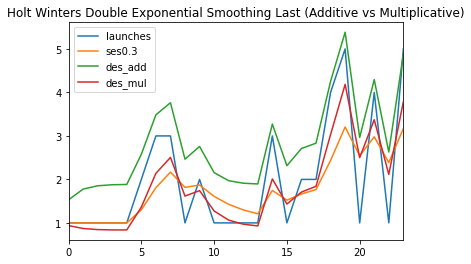

In [53]:
# Visualise the output
casc_df[['launches','ses0.3', 'des_add','des_mul']].iloc[:24].plot(title='Holt Winters Double Exponential Smoothing Last (Additive vs Multiplicative)').autoscale(axis='x',tight=True)

# 6. Univariate Forecasting 

Based on the plots, let's try to build a model for the CASC launches using the <font style ="color:#00a19b">DES_add model.</font>

C:\Users\crystallwi.xiaujing\AppData\Local\Continuum\anaconda3\envs\env01\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation

C:\Users\crystallwi.xiaujing\AppData\Local\Continuum\anaconda3\envs\env01\lib\site-packages\statsmodels\tsa\holtwinters\model.py:80: RuntimeWarning:

overflow encountered in matmul



<AxesSubplot:title={'center':"Forecasts from Holt-Winters' multiplicative method"}>

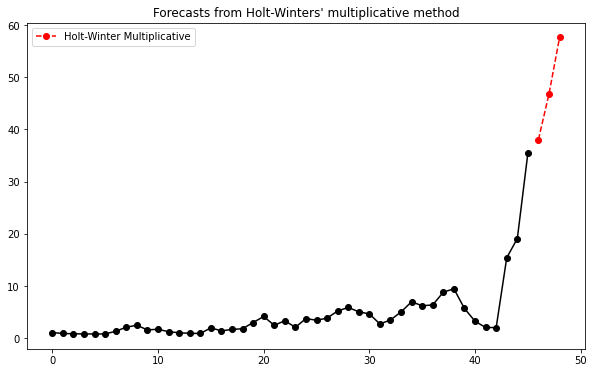

In [67]:
m1 = ExponentialSmoothing(casc_df['launches'], trend = 'mul').fit()
ax = m1.fittedvalues.plot(figsize=(10,6), marker='o', color='black', title="Forecasts from Holt-Winters' multiplicative method" )
m1.forecast(3).rename('Holt-Winter Multiplicative').plot(ax = ax, style = '--', color = 'red', legend = True, marker = 'o')

# 7. Time series decomposition

In [68]:
df['month_year'] = df['year'].astype(str) + '-' + df['month'].astype(str)
df['month_year'] = pd.to_datetime(df['month_year']).dt.to_period('M')
ds = df.groupby(['month_year'])['alpha3'].count().reset_index()
ds.columns = ['month_year', 'count']
ds['month_year'] = ds['month_year'].astype(str)

fig = px.line(
    ds, 
    x='month_year', 
    y='count', 
    orientation='v', 
    title='Launches by months' 
)

fig.show()

December 1971 is most active month for Launch attempts.

Let's do decomposition of time series of number of launches for every month.

In [69]:
dates = ['1957-10-01', '2020-08-02']
start, end = [datetime.strptime(_, "%Y-%m-%d") for _ in dates]
dd = pd.DataFrame(
    list(
        OrderedDict(((start + timedelta(_)).strftime(r"%Y-%m"), None) for _ in range((end - start).days)).keys()
    ), 
    columns=['date']
)
dd['date'] = pd.to_datetime(dd['date'])
ds['month_year'] = pd.to_datetime(ds['month_year'])
res = pd.merge(ds, dd, how='outer', left_on='month_year', right_on='date')
res = res.sort_values('date')[['date', 'count']]
res = res.fillna(0).set_index('date')

ipykernel_launcher:1: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



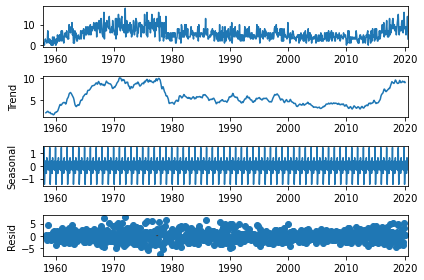

In [70]:
# Use seasonal_decompose on res, (model = 'additive', period = 12). Visualise the results.
result = seasonal_decompose(res, model='additive', period=12)
fig = result.plot()
matplotlib.rcParams['figure.figsize'] = [20, 15]

plt.show()

Let's drop noise from time series

In [71]:
ts = (result.trend + result.seasonal).reset_index()
ts.columns = ['date', 'count']
ts['origin'] = 'cleaned'
dres = res.reset_index()
dres['origin'] = 'original'
data = pd.concat([dres, ts])

In [73]:
fig = px.line(
    data, 
    x='date', 
    y='count', 
    color='origin', 
    orientation='v', 
    title='Original and cleaned time series', 
    width=700
)

fig.show()

### Simple ARIMA modeling

C:\Users\crystallwi.xiaujing\AppData\Local\Continuum\anaconda3\envs\env01\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


C:\Users\crystallwi.xiaujing\AppData\Local\Continuum\anaconda3\envs\env01\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning:


statsmodels.tsa.arima

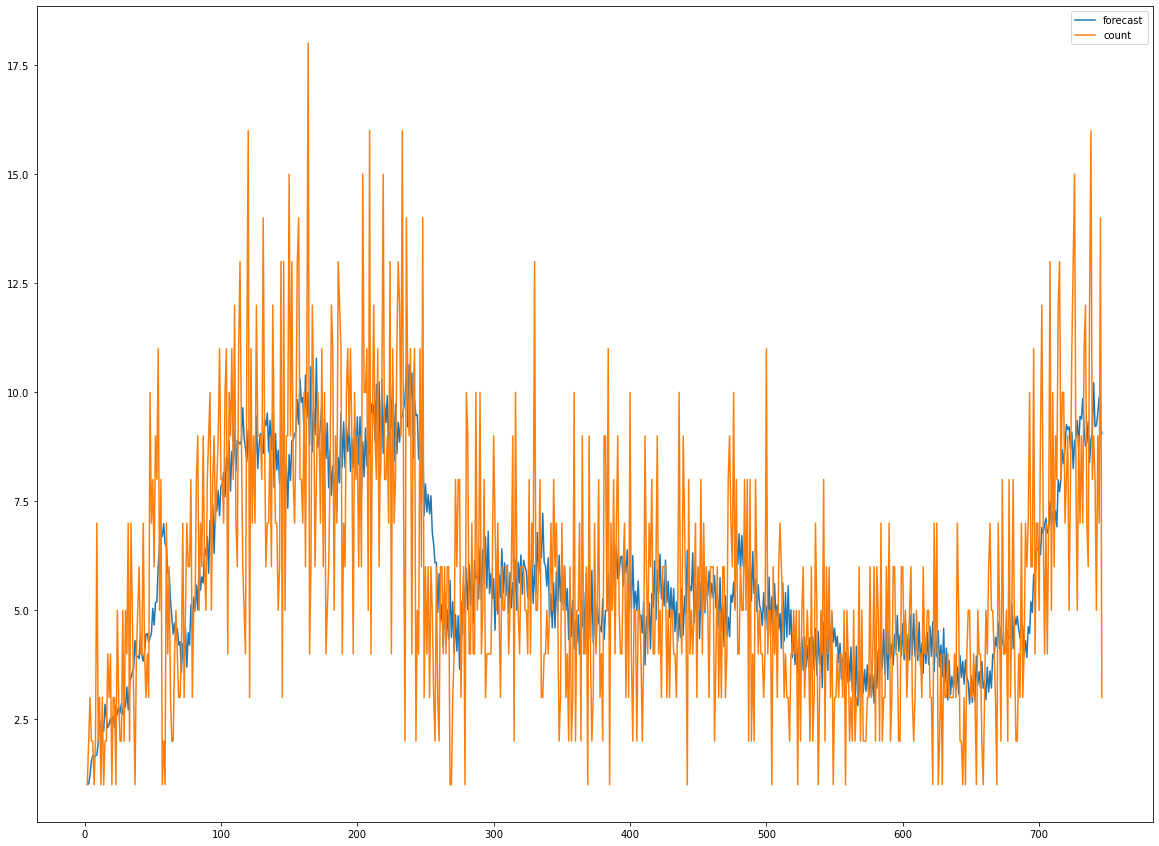

In [77]:
model = ARIMA(ds['count'], order=(10,1,2))
model_fit = model.fit()

model_fit.plot_predict(dynamic=False)

plt.show()

In [78]:
preds, _, _ = model_fit.forecast(16)
preds = preds.tolist()
preds = [int(item) for item in preds]
months = [
    '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01', 
    '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', 
    '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01', 
    '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01'
]

new_df = pd.DataFrame()
new_df['month_year'] = months
new_df['count'] = preds
data = pd.concat([ds, new_df])

fig = px.line(
    data, 
    x="month_year", 
    y="count", 
    title='Launches per month prediction'
)

fig.show()

## END